# Starbucks Capstone Challenge
## Project Motivation
**The purpose of this project is to help Starbucks better decisions on sending out offers increase sales and potentially save money. By predicting whether a customer will respond to an offer, Starbucks can make smarter decisions on whether or not to send an offer.**

By sending offers to the RIGHT customers:
- Starbucks can boost brand recognition, customer loyalty, increase sales activities, promote a new product, etc.

By NOT sending offers to the RIGHT customers:
- Starbucks can save costs on the promotion event on customers **who would make purchases without offers**
- Starbucks can prevent customers to react negatively to an offer by not sending the offer

In [159]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, r2_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [113]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


# Create customer_funnels dataset to analyze offer response

In [114]:
# Add offer info into events dataset
events = pd.merge(events, offers[['id','offer']], how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)
events.offer.unique()

array(['bogo_5_7_5', 'discount_20_10_5', 'discount_10_7_2',
       'discount_10_10_2', 'bogo_10_5_10', 'bogo_5_5_5', 'discount_7_7_3',
       'informational_0_4_0', 'bogo_10_7_10', 'informational_0_3_0', nan],
      dtype=object)

In [115]:
# Store offer types
informational_offers = ['informational_0_3_0','informational_0_4_0']
discount_offers = ['discount_20_10_5','discount_10_7_2','discount_10_10_2','discount_7_7_3']
bogo_offers = ['bogo_5_7_5','bogo_10_5_10','bogo_5_5_5','bogo_10_7_10']

# Remove informational events out of events data
informational_events = events[events.offer.isin(informational_offers)]
offer_events = events[~events.offer.isin(informational_offers)]

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']

In [116]:
# Create customer_funnels dataset
customer_funnels = offer_events.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels['completion_rate'] = customer_funnels.offer_completed / customer_funnels.offer_received
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
855dc7295b6745ce8a2791ac508193b5,NaN,4.0,1.0,NaN
122a741031304528b505e950ad3ad748,NaN,4.0,2.0,NaN
04dc7c54fc8147069875a5def52d711e,6.0,6.0,2.0,1.0
cd34d07a21c84d72b9856515a04f8efa,NaN,4.0,3.0,NaN
b94e988ed63a498aab070a6a64458812,NaN,2.0,1.0,NaN


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [117]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
completion_rate    24.539225
dtype: float64

## Define Customer Response
**A user can receive an offer, never actually view the offer, and still complete the offer.**  
**As a result, we want to segment all customers into 3 groups:**
- **responded**
    - customers who were influenced by the offer and made a purchase - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- **not_responded**
    - customers who were not influenced by the offer and didn't make a purchase - those who **RECEIVED, VIEWED, AND NOT COMPLETED THE OFFER**
- **completed_not_viewed**
    - customers who were not influenced by the offer but did make a purchase - those who **RECEIVED, NOT VIEWED, BUT COMPLETED THE OFFER**

In [118]:
def create_3_demo_groups(funnel):

    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    completed_not_viewed = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% customers responded to offers')
    print(round(len(not_responded)/len(funnel)*100,2), '% customers did not respond to any offer')
    print(round(len(completed_not_viewed)/len(funnel)*100,2), '% customers completed offers without viewing offer')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(completed_not_viewed) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, completed_not_viewed

### customer_funnels represents customer responses for all offers
So we know that for all offers:
- 74.4 % customers responded to offers
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed offers without viewing offer

**Later on, the funnel input for the above function can be funnels for a specific offer, to analyze each offer individually**

In [119]:
responded, not_responded, completed_not_viewed = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [120]:
def get_customer_ids(response_group):

    df = response_group
    return df.index

In [121]:
get_customer_ids(responded)

Index(['0009655768c64bdeb2e877511632db8f', '0011e0d4e6b944f998e987f904e8c1e5',
       '0020c2b971eb4e9188eac86d93036a77', '0020ccbbb6d84e358d3414a3ff76cffd',
       '003d66b6608740288d6cc97a6903f4f0', '00426fe3ffde4c6b9cb9ad6d077a13ea',
       '004b041fbfe44859945daa2c7f79ee64', '004c5799adbf42868b9cff0396190900',
       '005500a7188546ff8a767329a2f7c76a', '0056df74b63b4298809f0b375a304cf4',
       ...
       'ffd53e5ba61d41378b66efc00d9f9682', 'ffda4545e7084ff6aaf01304fb1c1fa6',
       'ffdefcac307f4ca99ac1ebd51470f106', 'ffe5257abf8840b395e1ee6b29894637',
       'ffeaa02452ef451082a0361c3ca62ef5', 'fff29fb549084123bd046dbc5ceb4faa',
       'fff3ba4757bd42088c044ca26d73817a', 'fff7576017104bcc8677a8d63322b5e1',
       'fffad4f4828548d1b5583907f2e9906b', 'ffff82501cea40309d5fdd7edcca4a07'],
      dtype='object', name='customer_id', length=12595)

### Analyze demographics for the 3 response groups
- If we look at the "not responded" group (orange distribution), we can conclude that customers with young age, low income, and a short period of membership are likely to not respond to offers
- The green and blue distributions are relatively similar, while the green distribution (completed the offer without viewing) is slightly skewed to higher age, higher income, and longer membership period

In [122]:
def plot_compare_3_groups(funnel):

    responded, not_responded, completed_not_viewed = create_3_demo_groups(funnel)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].age, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].age, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].age, label='completed not viewed');
    plt.legend();

    plt.subplot(1,3,2)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].income, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].income, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].income, label='completed not viewed');
    plt.legend();

    plt.subplot(1,3,3)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].membership_days, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].membership_days, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].membership_days, label='completed not viewed');
    plt.legend();

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


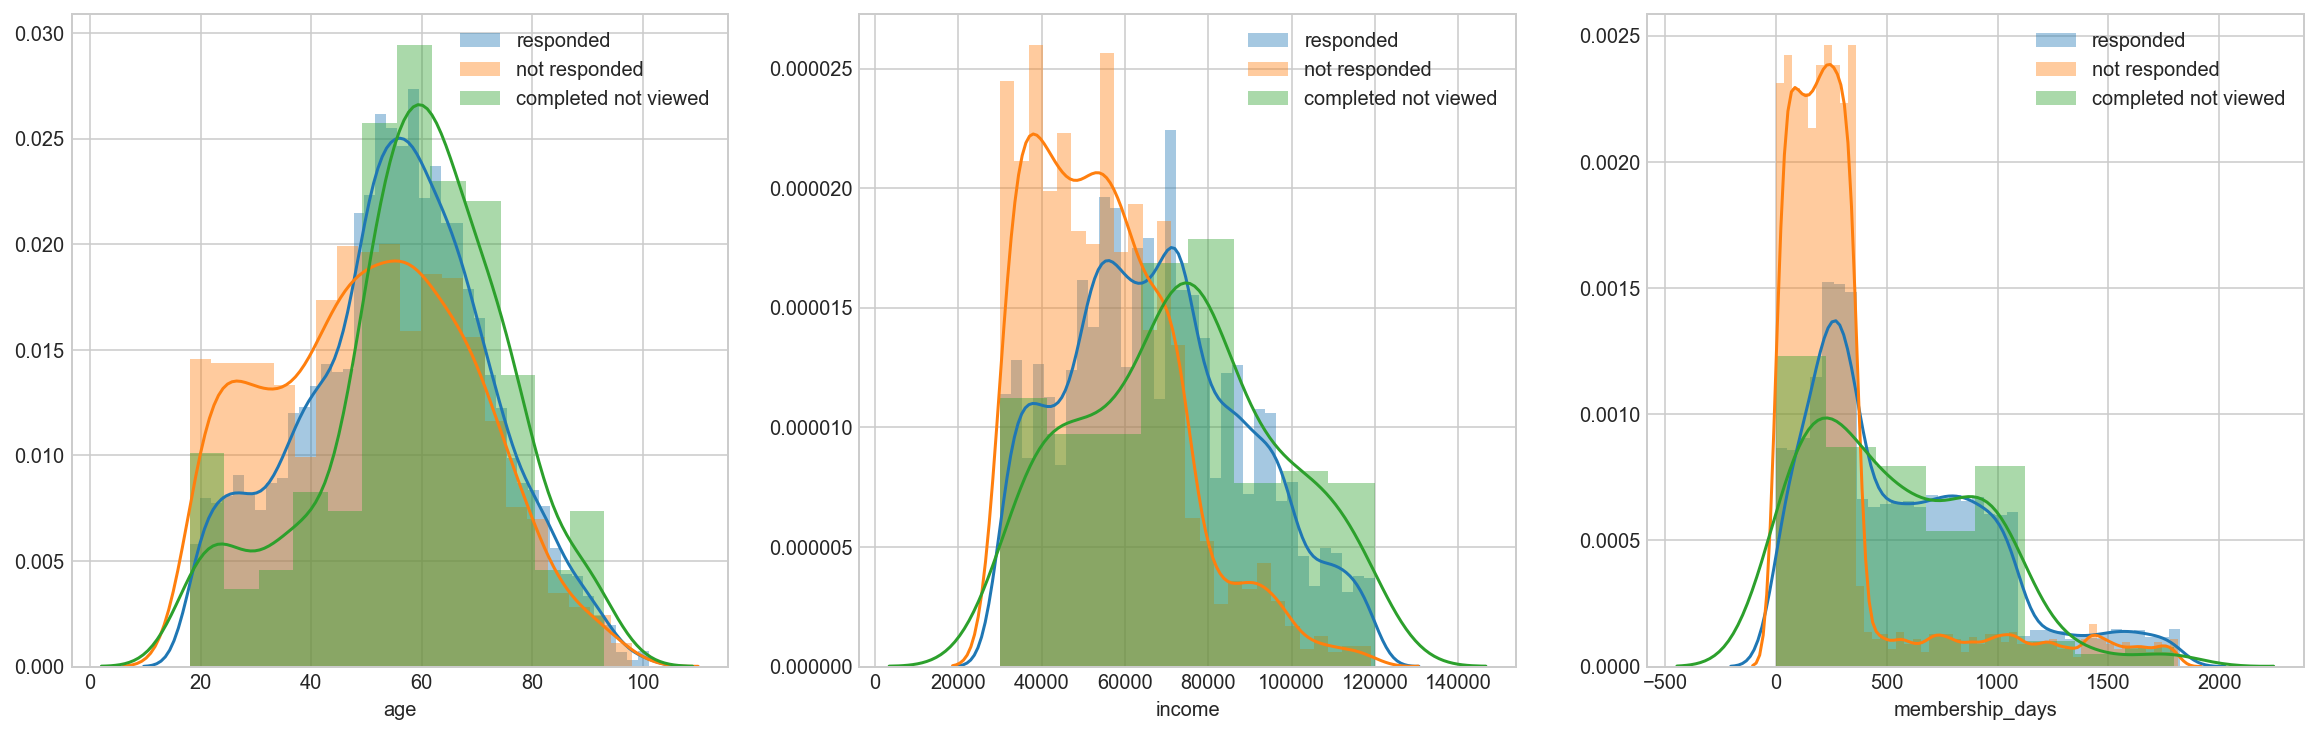

In [64]:
plot_compare_3_groups(customer_funnels)

# Dig deeper into customers funnels by seperating offers

In [96]:
def create_offer_funnels(offer):

    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]
    funnel['completion_rate'] = funnel.offer_completed / funnel.offer_received

    return funnel

In [97]:
create_offer_funnels('discount_7_7_3').sample(5)

,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
2537d7d802c84a44875012770887c4e9,NaN,1.0,1.0,NaN
1ebff9c4dddc439e864de60c6fe01fb6,NaN,1.0,NaN,NaN
b420d078191046d889916e7688181122,2.0,2.0,2.0,1.0
e262142cfb3f4c87ab26ba7dd09562aa,1.0,1.0,1.0,1.0
f760c17c8e72437ab9498ec9a866e69a,NaN,1.0,1.0,NaN


# Analyze customer response for the 4 discount offers

In [98]:
discount_offers

['discount_20_10_5', 'discount_10_7_2', 'discount_10_10_2', 'discount_7_7_3']

23.09 % customers responded to offers
53.28 % customers did not respond to any offer
23.63 % customers completed offers without viewing offer


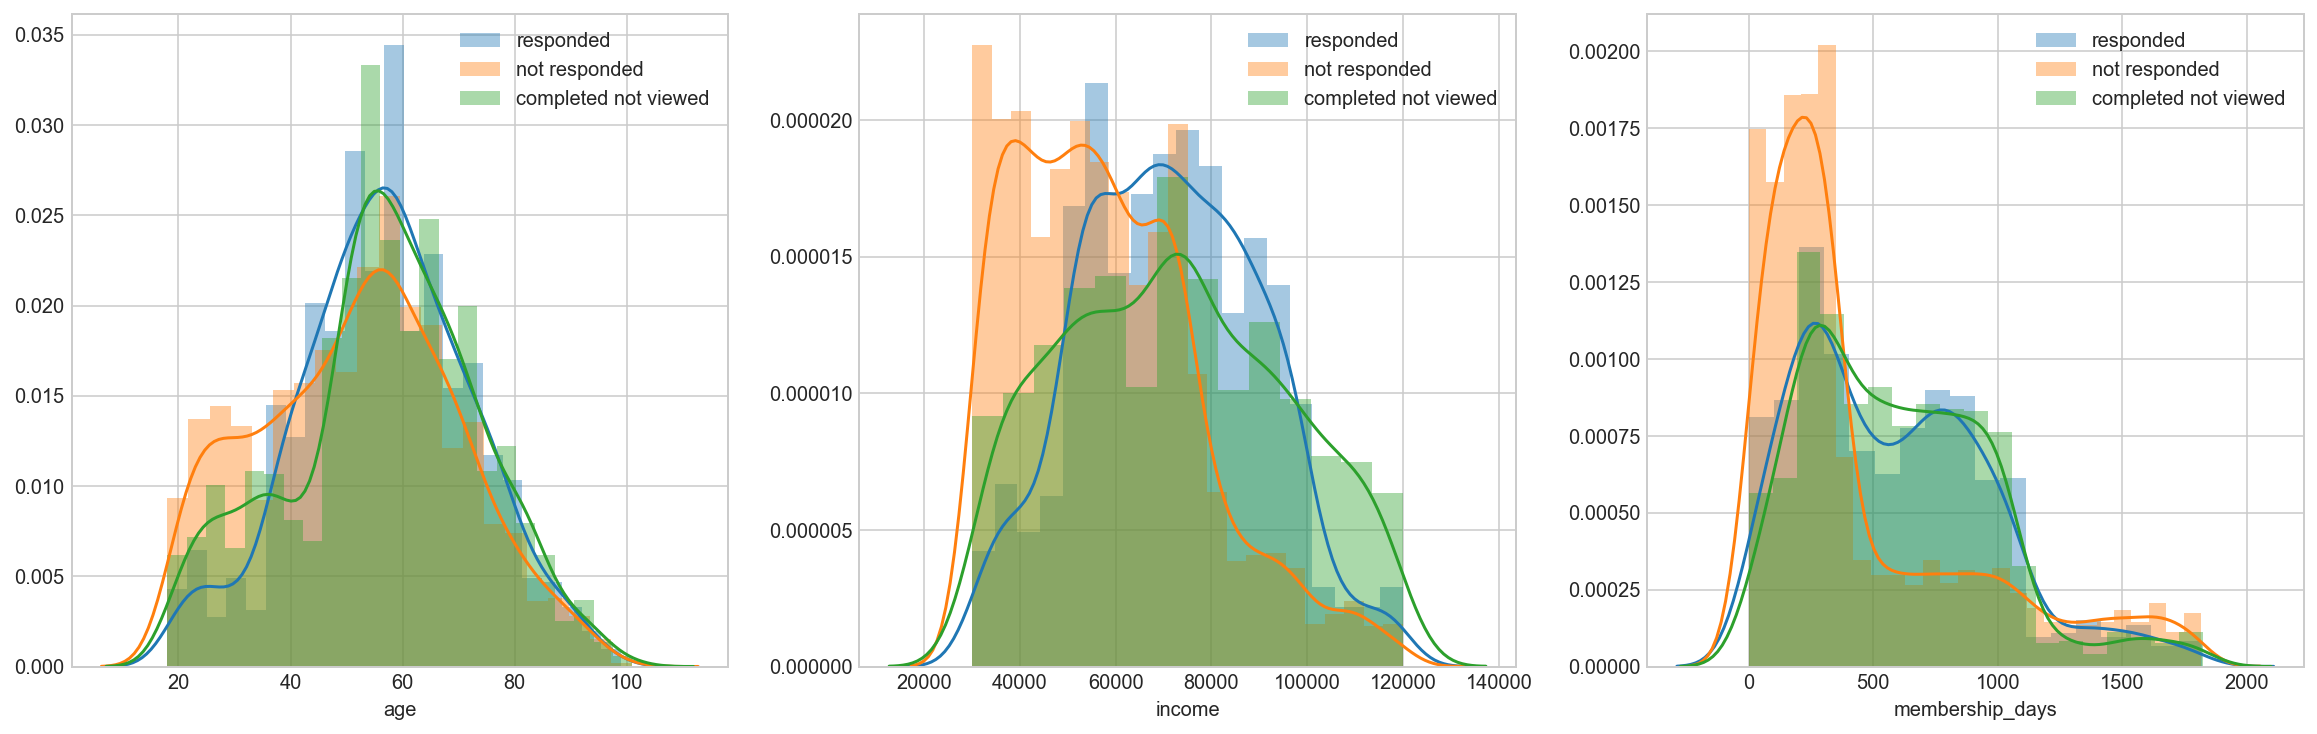

In [69]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5'))

38.42 % customers responded to offers
44.63 % customers did not respond to any offer
16.95 % customers completed offers without viewing offer


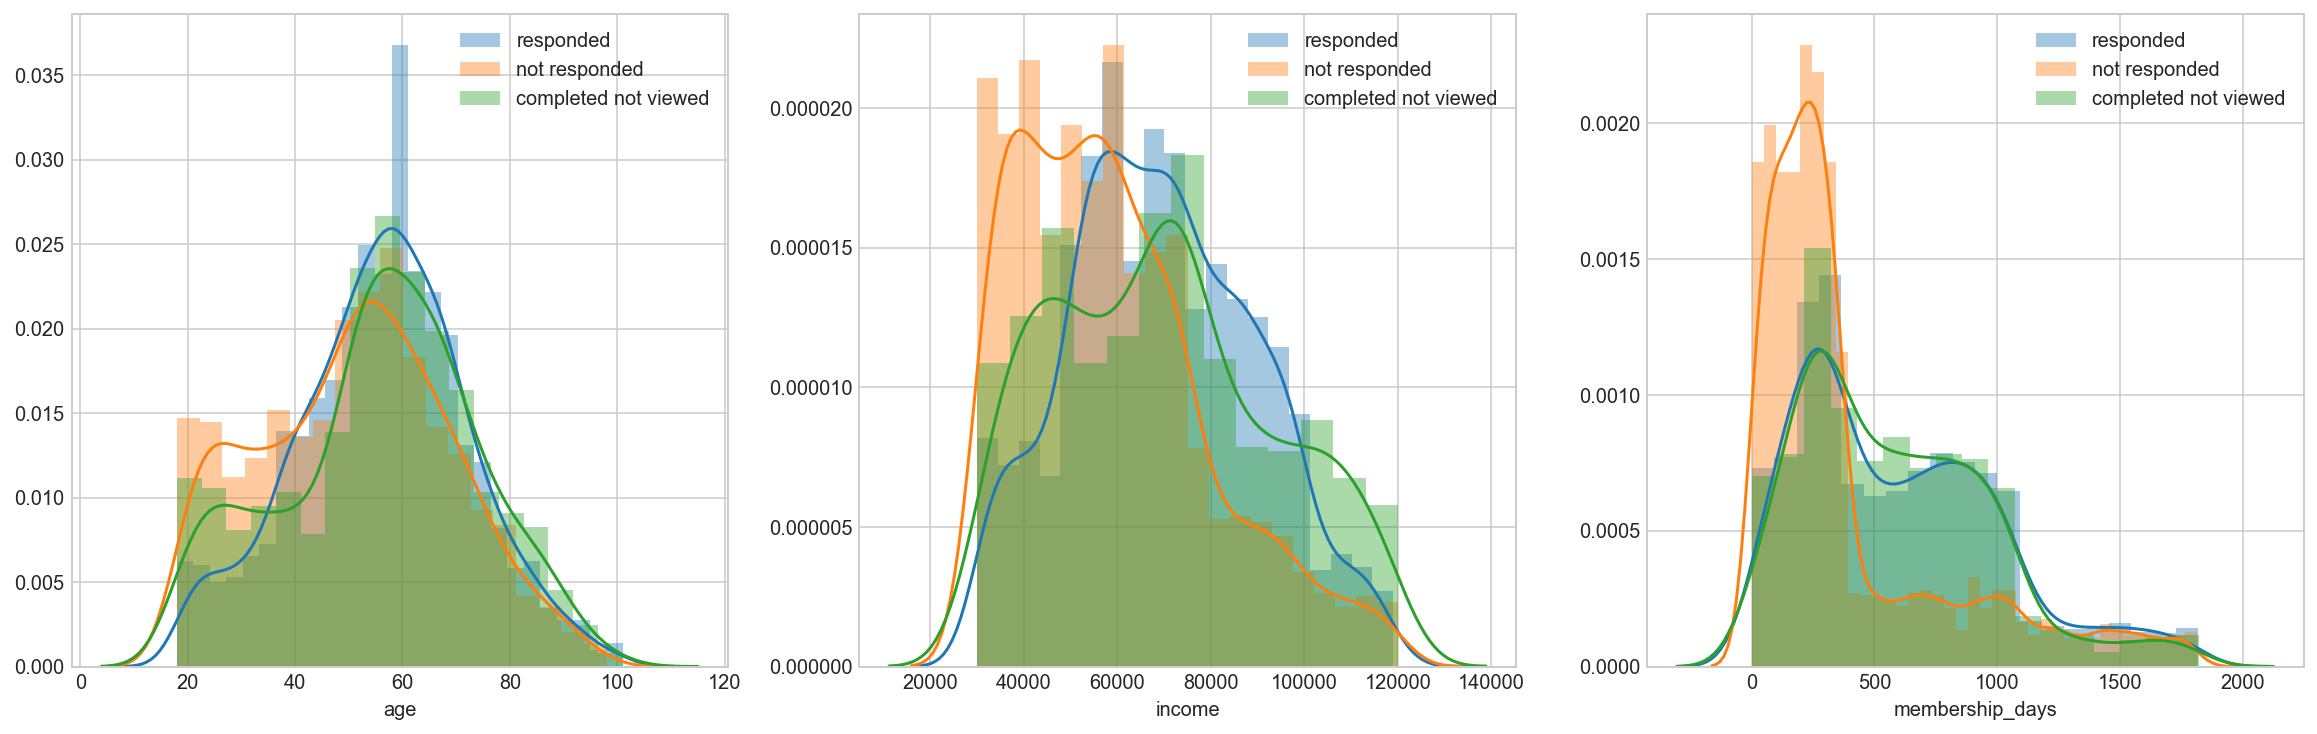

In [25]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2'))

70.01 % customers responded to offers
28.46 % customers did not respond to any offer
1.53 % customers completed offers without viewing offer


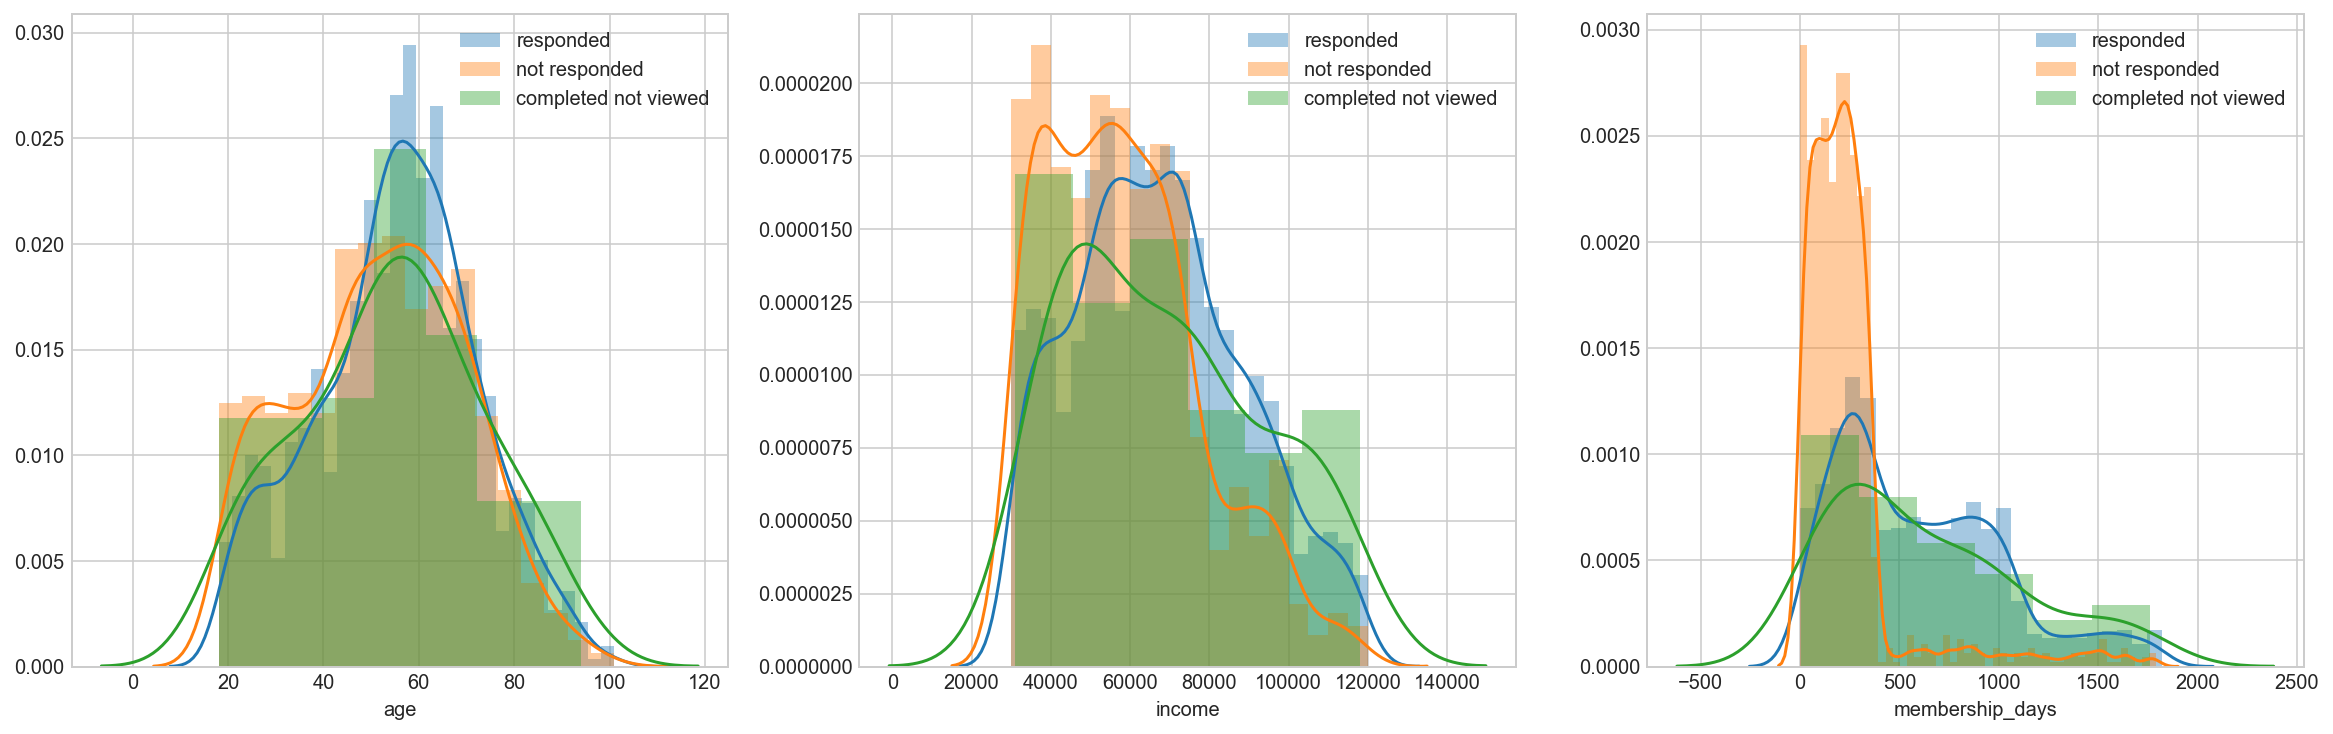

In [26]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2'))

68.19 % customers responded to offers
30.1 % customers did not respond to any offer
1.71 % customers completed offers without viewing offer


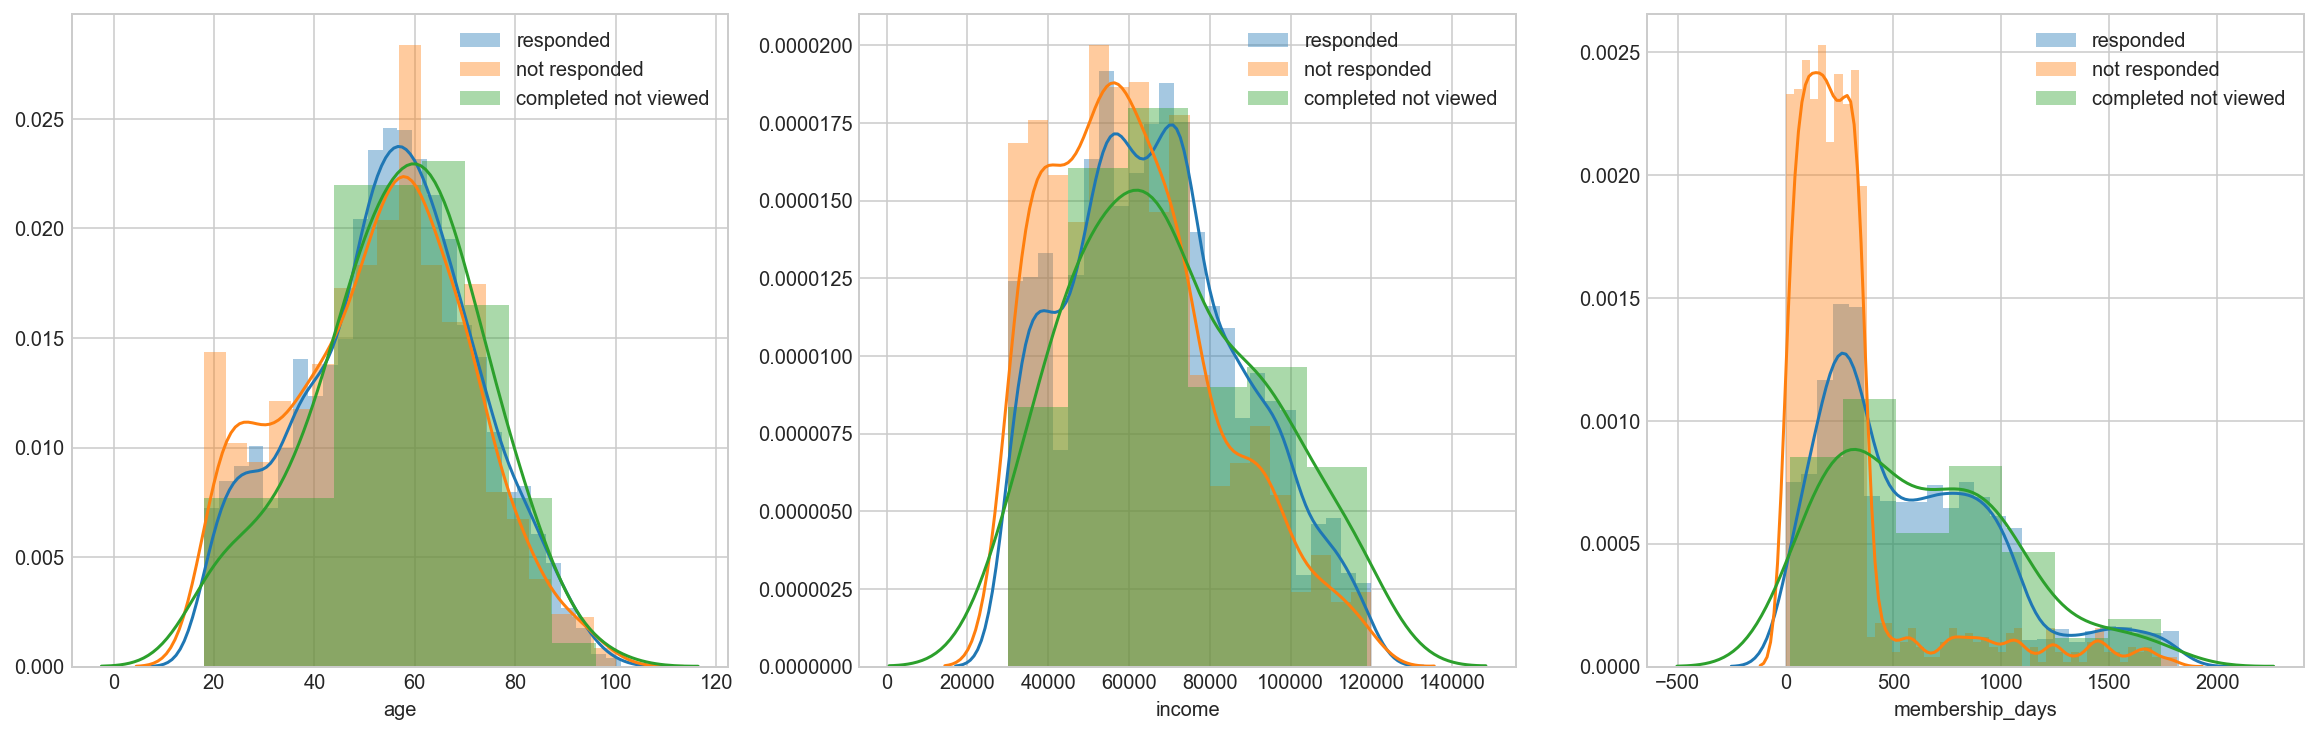

In [21]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3'))

# Analyze customer response for the 4 BOGO offers

In [27]:
bogo_offers

['bogo_5_7_5', 'bogo_10_5_10', 'bogo_5_5_5', 'bogo_10_7_10']

39.4 % customers responded to offers
40.46 % customers did not respond to any offer
20.14 % customers completed offers without viewing offer


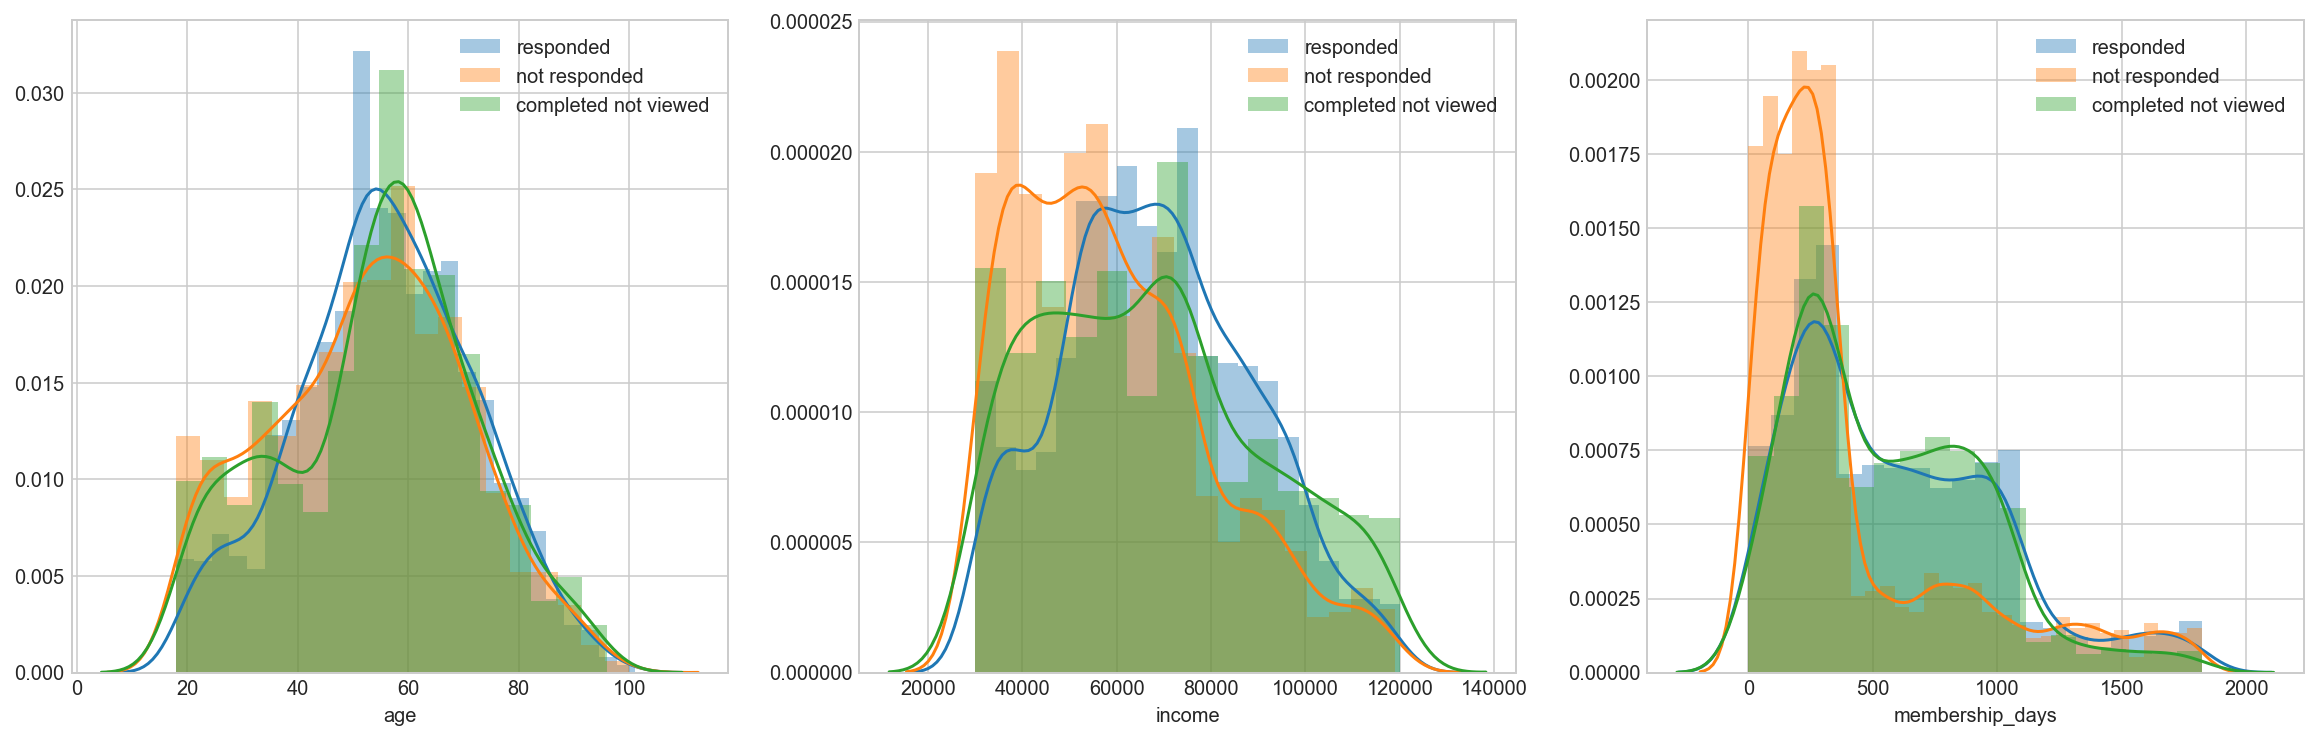

In [28]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5'))

44.63 % customers responded to offers
54.42 % customers did not respond to any offer
0.95 % customers completed offers without viewing offer


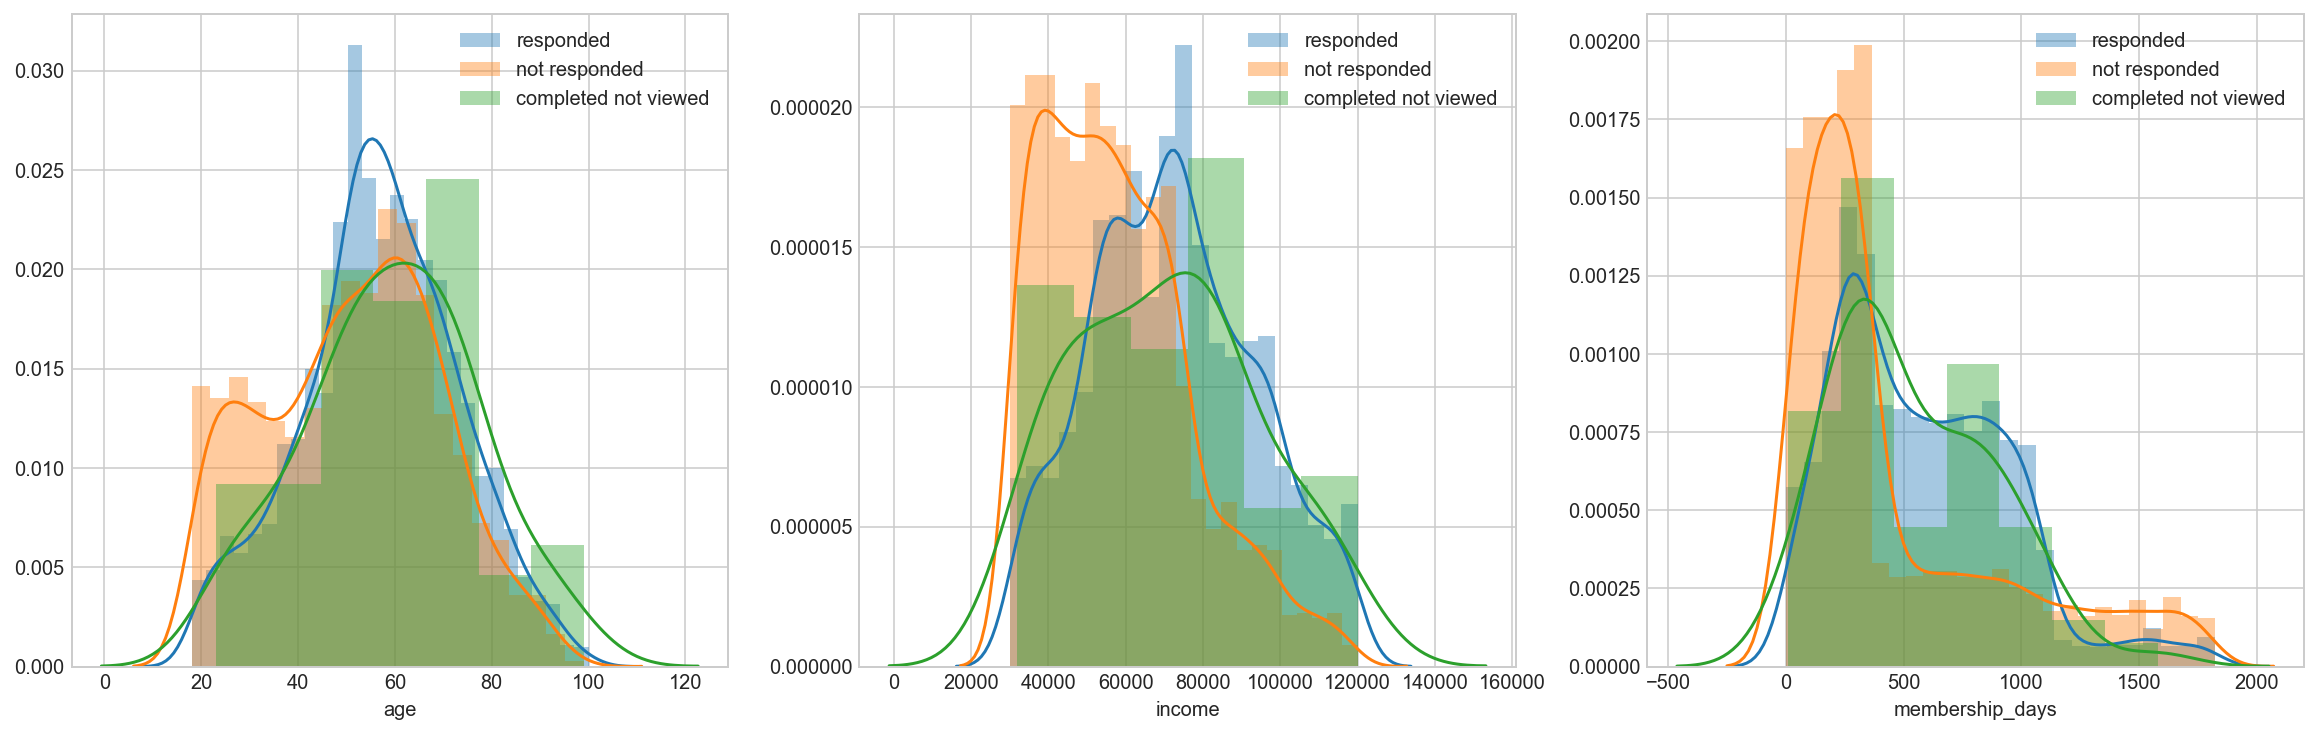

In [29]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10'))

58.37 % customers responded to offers
40.26 % customers did not respond to any offer
1.37 % customers completed offers without viewing offer


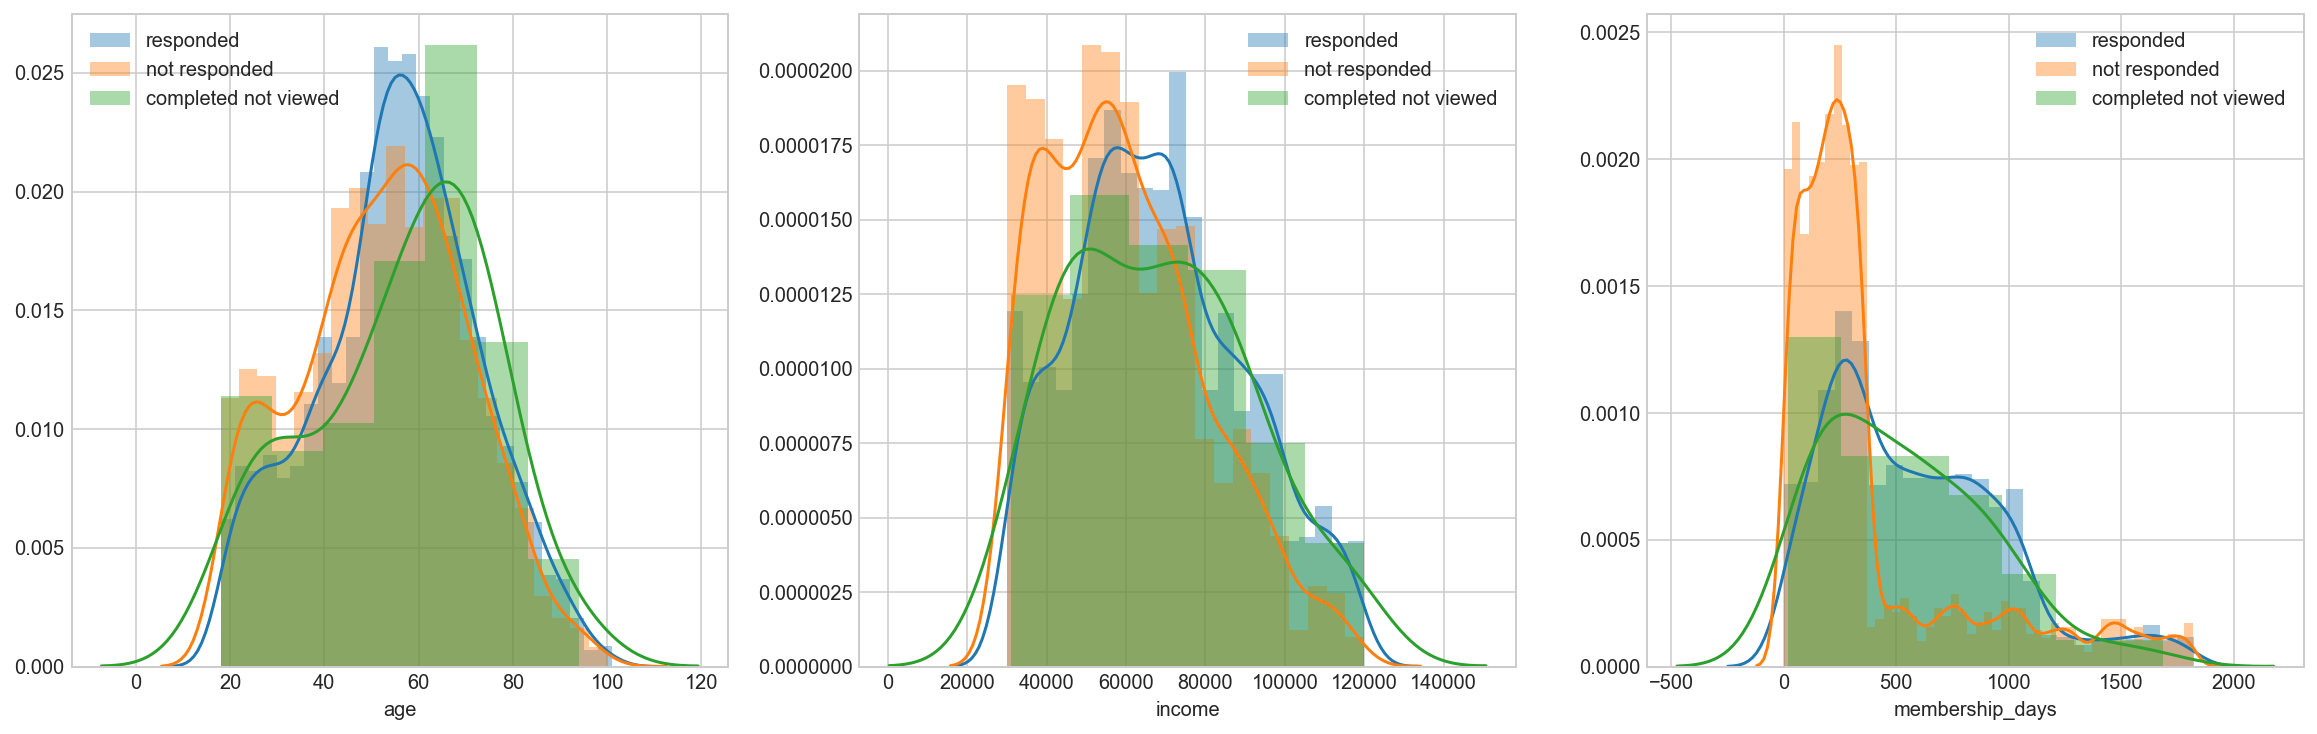

In [30]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5'))

44.6 % customers responded to offers
50.16 % customers did not respond to any offer
5.24 % customers completed offers without viewing offer


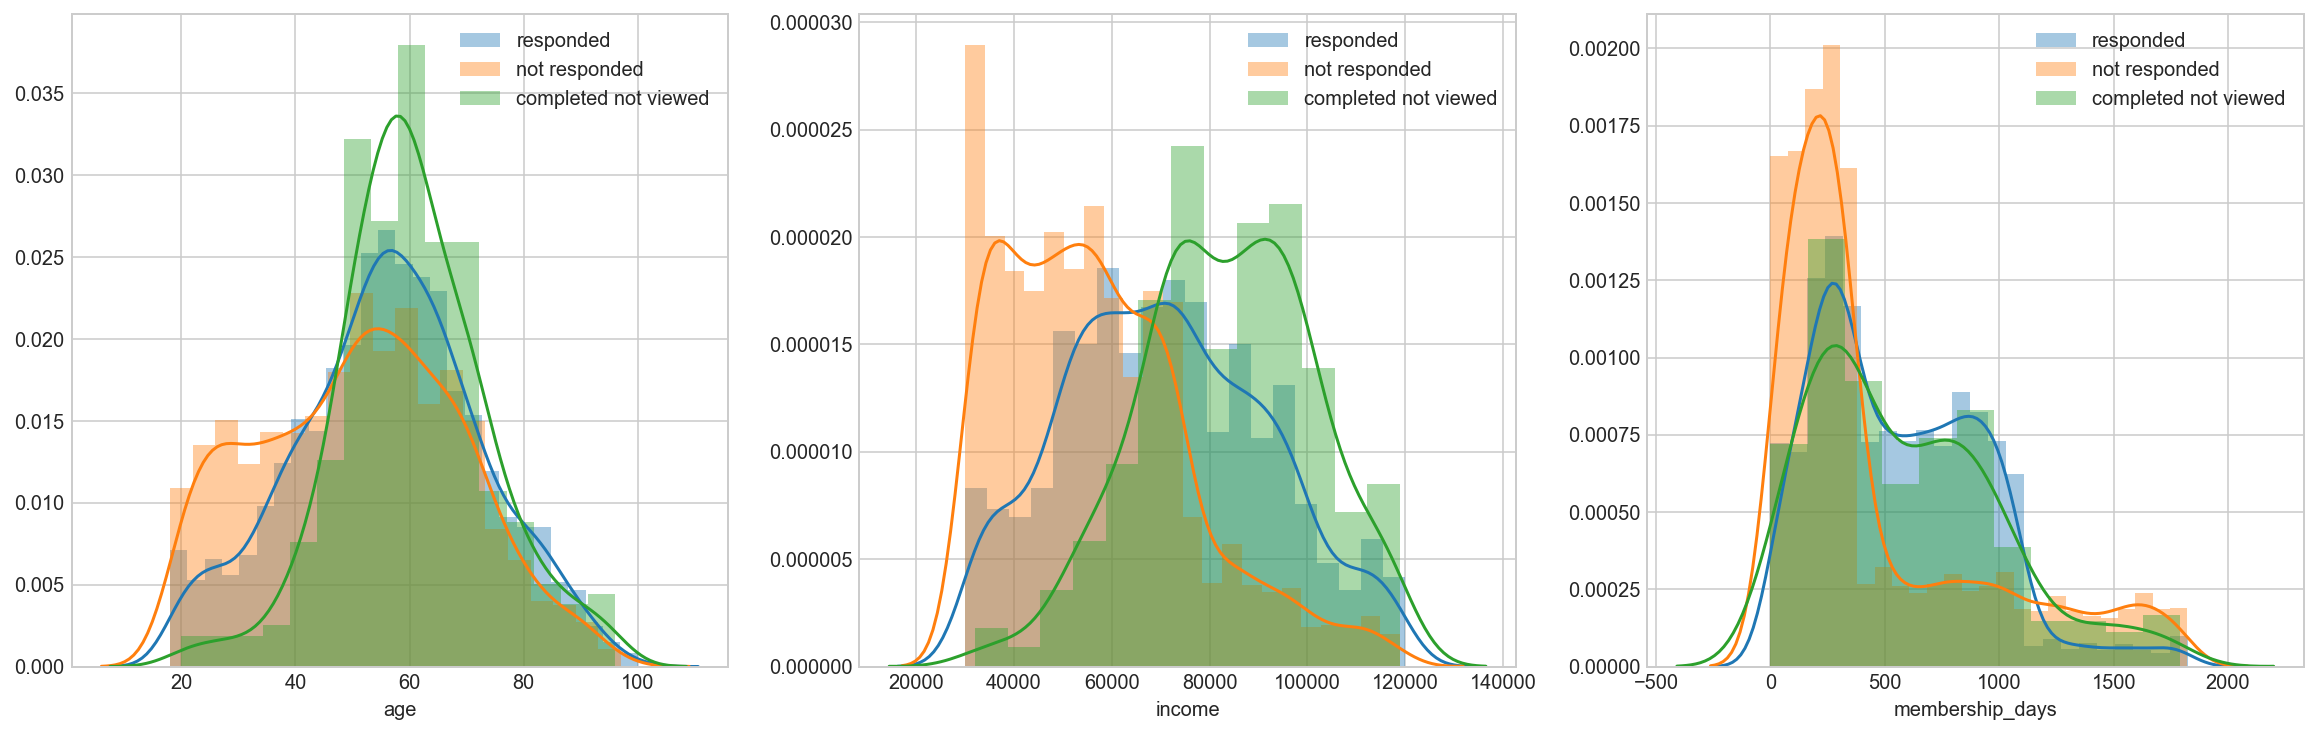

In [31]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10'))

### Implementation
While we have a function to extract customer ids based on offer_type and offer_id, we can create new features in the customers data - whether the customer responded to offer A, offer B, ... discount offers, BOGO offers, etc.

In [123]:
responded, not_responded, completed_not_viewed = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [125]:
customers['response'] = customers.id.isin(responded.index).astype(int)
customers = pd.merge(customers, customer_funnels[['completion_rate']].reset_index(), how='left', left_on='id', right_on='customer_id').drop('customer_id',axis=1)
customers.head()

,gender,age,id,income,membership_days,response,completion_rate
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,1,0.4
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,0,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,1.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,0,NaN


### The reason why this ratio is different is because customer_funnels has removed some customers with only informational offer events

In [127]:
# Examine the ratios of target classes to decide on the classification metrics
# Accuracy seems like a good metric for balanced classes
print('response ratios:')
print(customers.response.value_counts() / len(customers))

response ratios:
1    0.741144
0    0.258856
Name: response, dtype: float64


In [137]:
customers.completion_rate.fillna(0, inplace=True)
customers.dropna(inplace=True)

In [138]:
customers.isnull().mean()

gender             0.0
age                0.0
id                 0.0
income             0.0
membership_days    0.0
response           0.0
completion_rate    0.0
dtype: float64

 # Build Models to classify customer response to offers
- By predicting whether a customer will respond to a certain type of offer (discount / bogo), we can build focused marketing campaigns to maximize returns

## Notes:
- 55% of customers responded to discount offers while 45% didn't respond
- 51% of customers responded to bogo offers while 48 percent didn't respond
- Although classes are balanced, I would still choose F1 score as the metric
- Because I'd like to make sure all customers who will respond gets the offer, in the expense of those who won't respond getting the offer

In [129]:
customers.head()

,gender,age,id,income,membership_days,response,completion_rate
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,1,0.4
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,0,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,1.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,0,NaN


In [139]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days']]
y = customers['response']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)

## Compare ROC AUC for both target variables (discount, bogo)

In [142]:
def compare_roc():

    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title('ROC comparison')

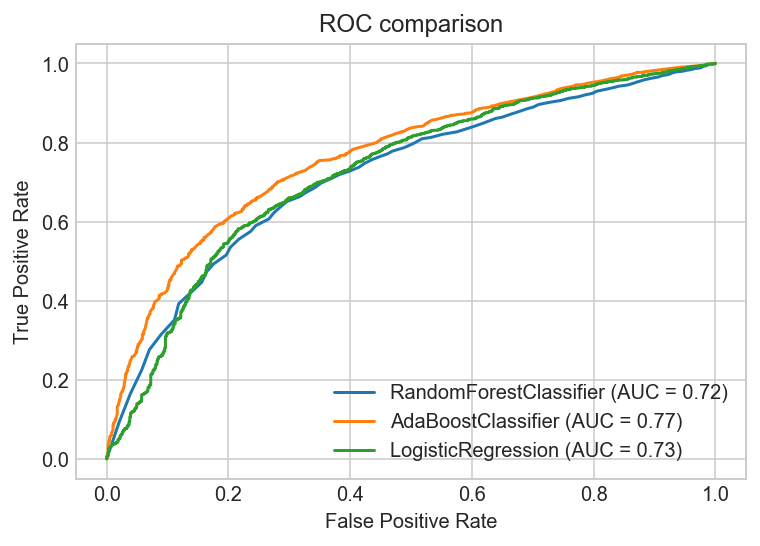

In [143]:
compare_roc()

# Use GridSearchCV to find the best parameters for AdaBoost

In [144]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 10}
f1 score on the testset: 0.8941041785918717
accuracy on the testset: 0.812753036437247


### Find the optimal probability threshold for the highest F1 scores
- In practice, we can lower the threshold because there is little harm to send offers to those who won't respond

In [150]:
# def find_best_threshold(model, plot=False):

#     # create a hash table of thresholds vs f1 scores
#     res = dict()
#     y_proba_pred = model.predict_proba(X_test)[:,1]

#     for threshold in np.linspace(0,1):
#         res[threshold] = f1_score(y_test, [1 if p > threshold else 0 for p in y_proba_pred])

#     # Find the optimal probability thresholds for the max f1 score
#     for key,value in res.items():
#         if value == max(res.values()):
#             print(key)

#     if plot == True:
#         # plot probability threshold VS F1 scores
#         plt.plot(list(res.keys()), list(res.values()));
#         plt.title('F1 scores by probability thresholds');

In [151]:
# # The best threshold for predicting bogo response is between 0.28 and 0.34 for this test data
# find_best_threshold(model, plot=True)

In [155]:
y = customers['completion_rate']
y

1        1.000000
3        1.000000
5        0.666667
8        0.833333
12       0.500000
           ...   
16989    0.000000
16990    1.000000
16991    0.000000
16992    1.000000
16993    1.000000
Name: completion_rate, Length: 14820, dtype: float64

,age,income,membership_days,gender_F,gender_M,gender_O
1,55.0,112000.0,376,1,0,0
3,75.0,100000.0,443,1,0,0
5,68.0,70000.0,91,0,1,0
8,65.0,53000.0,167,0,1,0
12,58.0,51000.0,257,0,1,0
...,...,...,...,...,...,...
16989,45.0,54000.0,52,1,0,0
16990,61.0,72000.0,13,0,1,0
16991,49.0,73000.0,546,0,1,0
16992,83.0,50000.0,871,1,0,0


In [162]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50, 70],
    'learning_rate': [0.1, 0.5, 1, 3],
}

model = GridSearchCV(AdaBoostRegressor(), param_grid=parameters, scoring='r2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'R-squared score on the testset: {r2_score(y_test, y_pred)}')
# print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
R-squared score on the testset: 0.24276290499943998


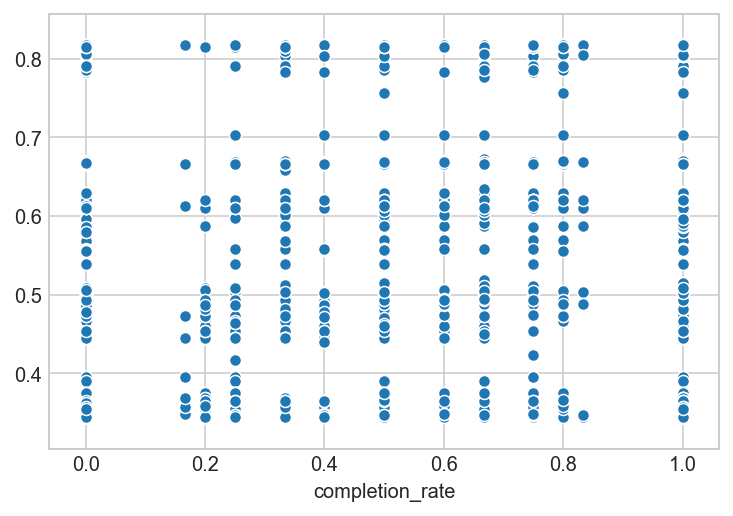

In [164]:
sns.scatterplot(x=y_test, y=y_pred)